In [ ]:
source("/root/workspace/wj/Workspace/Vscode_Workspace/single-cell-continue/MIRACLE-master/preprocess/utils.R")
setwd("/root/workspace/wj/Workspace/Vscode_Workspace/single-cell-continue/MIRACLE-master/")
library(RColorBrewer)
library(patchwork)

parser <- ArgumentParser()
parser$add_argument("--task", type = "character", default = "single_asap_cl")
parser$add_argument("--method", type = "character", default = "midas_embed")
parser$add_argument("--experiment", type = "character", default = "c_1")
parser$add_argument("--model", type = "character", default = "default")
parser$add_argument("--init_model", type = "character", default = "")
parser$add_argument("--reference", type = "character", default = "atlas_new_no_neap")
o <- parser$parse_known_args()[[1]]

config <- parseTOML("configs/data.toml")[[gsub("_transfer$|_ref_.*$", "", o$task)]]
config_ref <- parseTOML("configs/data.toml")[[gsub("_transfer$|_ref_.*$", "", o$reference)]]
config$raw_data_dirs <- c(config_ref$raw_data_dirs, config$raw_data_dirs)
subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
input_dirs <- pj("result", o$task, o$experiment, o$model, "predict", o$init_model, paste0("subset_", subset_ids))
pp_dir <- pj("data", "processed", o$reference)
output_dir <- pj("result", "comparison", o$task, o$method, o$experiment, o$init_model)
mkdir(output_dir, remove_old = F)
label_paths <- pj(config$raw_data_dirs, "label_seurat_cca", "l1.csv")

K <- parseTOML("configs/model.toml")[["default"]]$dim_c
l <- 7.5  # figure size
L <- 10   # figure size
m <- 0.5  # legend margin

## Load preprossed data

In [ ]:
z_list <- list()
cell_name_list <- list()
label_list <- list()
is_label <- T
subset_name_list <- list()
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]
    z_dir    <- pj(input_dirs[i], "z", "joint")
    fnames <- dir(path = z_dir, pattern = ".csv$")
    fnames <- str_sort(fnames, decreasing = F)

    z_subset_list <- list()
    N <- length(fnames)
    for (n in seq_along(fnames)) {
        message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
        z_subset_list[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
    }
    z_list[[subset_name]] <- bind_rows(z_subset_list)

    if (i < 29) {
        cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
            "cell_names.csv"), header = T)[, 2]
    } else {
        cell_name_list[[subset_name]] <- read.csv(pj(pj("data", "processed", o$task), paste0("subset_", as.numeric(subset_ids[i])-28),
            "cell_names.csv"), header = T)[, 2]
    }
    if (file.exists(label_paths[i])) {
        if (grepl('lane', subset_names[i])) {
            label_list[[subset_name]] <- read.csv(gsub("l1.csv", "l1_singler.csv", label_paths[i]), header = T)[, 2]
        } else {
            label_list[[subset_name]] <- read.csv(label_paths[i], header = T)[, 2]
        }
    } else {
        is_label <- F
    }
    
    subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
}

Loading Subset 1/34, File 1/29

Loading Subset 1/34, File 2/29

Loading Subset 1/34, File 3/29

Loading Subset 1/34, File 4/29

Loading Subset 1/34, File 5/29

Loading Subset 1/34, File 6/29

Loading Subset 1/34, File 7/29

Loading Subset 1/34, File 8/29

Loading Subset 1/34, File 9/29

Loading Subset 1/34, File 10/29

Loading Subset 1/34, File 11/29

Loading Subset 1/34, File 12/29

Loading Subset 1/34, File 13/29

Loading Subset 1/34, File 14/29

Loading Subset 1/34, File 15/29

Loading Subset 1/34, File 16/29

Loading Subset 1/34, File 17/29

Loading Subset 1/34, File 18/29

Loading Subset 1/34, File 19/29

Loading Subset 1/34, File 20/29

Loading Subset 1/34, File 21/29

Loading Subset 1/34, File 22/29



Loading Subset 1/34, File 23/29

Loading Subset 1/34, File 24/29

Loading Subset 1/34, File 25/29

Loading Subset 1/34, File 26/29

Loading Subset 1/34, File 27/29

Loading Subset 1/34, File 28/29

Loading Subset 1/34, File 29/29

Loading Subset 2/34, File 1/24

Loading Subset 2/34, File 2/24

Loading Subset 2/34, File 3/24

Loading Subset 2/34, File 4/24

Loading Subset 2/34, File 5/24

Loading Subset 2/34, File 6/24

Loading Subset 2/34, File 7/24

Loading Subset 2/34, File 8/24

Loading Subset 2/34, File 9/24

Loading Subset 2/34, File 10/24

Loading Subset 2/34, File 11/24

Loading Subset 2/34, File 12/24

Loading Subset 2/34, File 13/24

Loading Subset 2/34, File 14/24

Loading Subset 2/34, File 15/24

Loading Subset 2/34, File 16/24

Loading Subset 2/34, File 17/24

Loading Subset 2/34, File 18/24

Loading Subset 2/34, File 19/24

Loading Subset 2/34, File 20/24

Loading Subset 2/34, File 21/24

Loading Subset 2/34, File 22/24

Loading Subset 2/34, File 23/24

Loading Subset 2/34

## Create seurat object

In [ ]:
rna <- t(data.matrix(bind_rows(z_list))) * 0  # pseudo rna counts
colnames(rna) <- do.call("c", unname(cell_name_list))
rownames(rna) <- paste0("rna-", seq_len(nrow(rna)))
obj <- CreateSeuratObject(counts = rna, assay = "rna")

z <- data.matrix(bind_rows(z_list))
c <- z[, 1:K]
colnames(c) <- paste0("c_", seq_len(ncol(c)))
rownames(c) <- colnames(obj)
obj[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "rna")

u <- z[, (K+1):(K+2)]
colnames(u) <- paste0("u_", seq_len(ncol(u)))
rownames(u) <- colnames(obj)
obj[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "rna")

obj@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list)), levels = subset_names)
table(obj@meta.data$batch)[unique(obj@meta.data$batch)]

obj


                lll_ctrl                 lll_stim                 dig_ctrl 
                    7361                     5897                    10190 
                dig_stim                       w1                       w3 
                    9527                     7325                     6587 
                      w4                       w5                       w6 
                    6897                     6910                     7137 
            tea_multi_w1             tea_multi_w2 10x_multiome_chrom_x_10k 
                    6096                     7284                     9868 
10x_multiome_chrom_c_10k    10x_multiome_arc2_10k     10x_multiome_arc2_3k 
                    9582                    11116                     2566 
               asap_ctrl                asap_stim                cite_ctrl 
                    4255                     5241                     5086 
               cite_stim                     p1_0                     p2_0 
           

An object of class Seurat 
34 features across 273250 samples within 1 assay 
Active assay: rna (34 features, 0 variable features)
 2 dimensional reductions calculated: c, u

## Visualization

In [ ]:
obj <- RunUMAP(obj, reduction = 'c', dims = 1:K, reduction.name = 'c.umap')
obj <- RunUMAP(obj, reduction = 'u', dims = 1:2, metric = "euclidean", reduction.name = 'u.umap')
# SaveH5Seurat(obj, pj(output_dir, "obj.h5seurat"), overwrite = TRUE)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
03:49:40 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

03:49:41 Read 275484 rows and found 32 numeric columns

03:49:41 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

03:49:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

03:50:41 Writing NN index file to

In [ ]:
obj <- AddMetaData(object = obj,     #seurat对象
                    metadata = do.call('c', label_list[1:34]),    #需要添加的metadata
                    col.name = "l1")

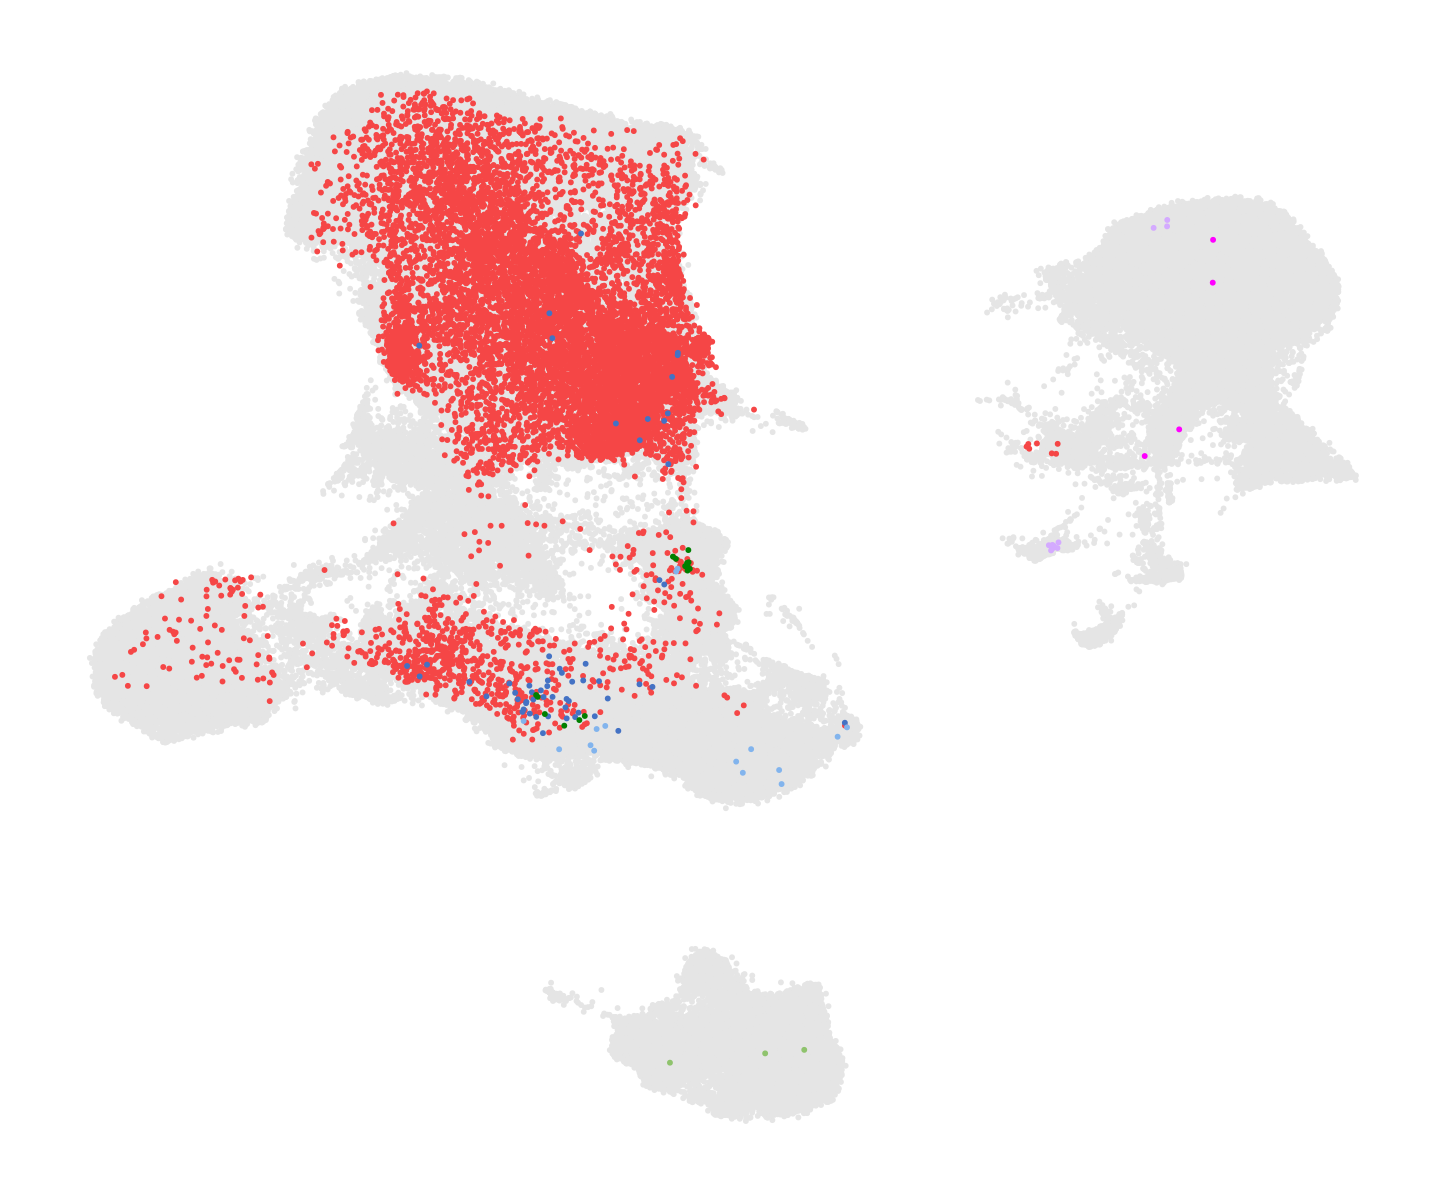

In [ ]:
# set groups for highlighting
obj@meta.data$highlight <- "Unselected"
select_mask <- obj@meta.data$batch %in% subset_names[29:30]

obj@meta.data$highlight[select_mask] <- as.character(obj@meta.data$l1[select_mask])

# Set colors
cell_label_unique <- unique(obj@meta.data$highlight[select_mask])
labels <- str_sort(cell_label_unique)

pal <- col_8
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")


# plot
p1 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = F, rater_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 1, 
              shuffle = F, cols = cols, legend = T, return_plt = T) +
    labs(colour = "Seurat cell type") + theme(legend.position = "none")
p1
save_path = paste0("/root/workspace/wj/Workspace/Vscode_Workspace/single-cell-continue/MIRACLE-master/analysis/fig/", "single_query_neat_c1_celltype")
ggsave(plot = p1, file = paste0(save_path, ".png"), width = L, height = L, limitsize = F)
ggsave(plot = p1, file = paste0(save_path, ".pdf"), width = L, height = L, limitsize = F)

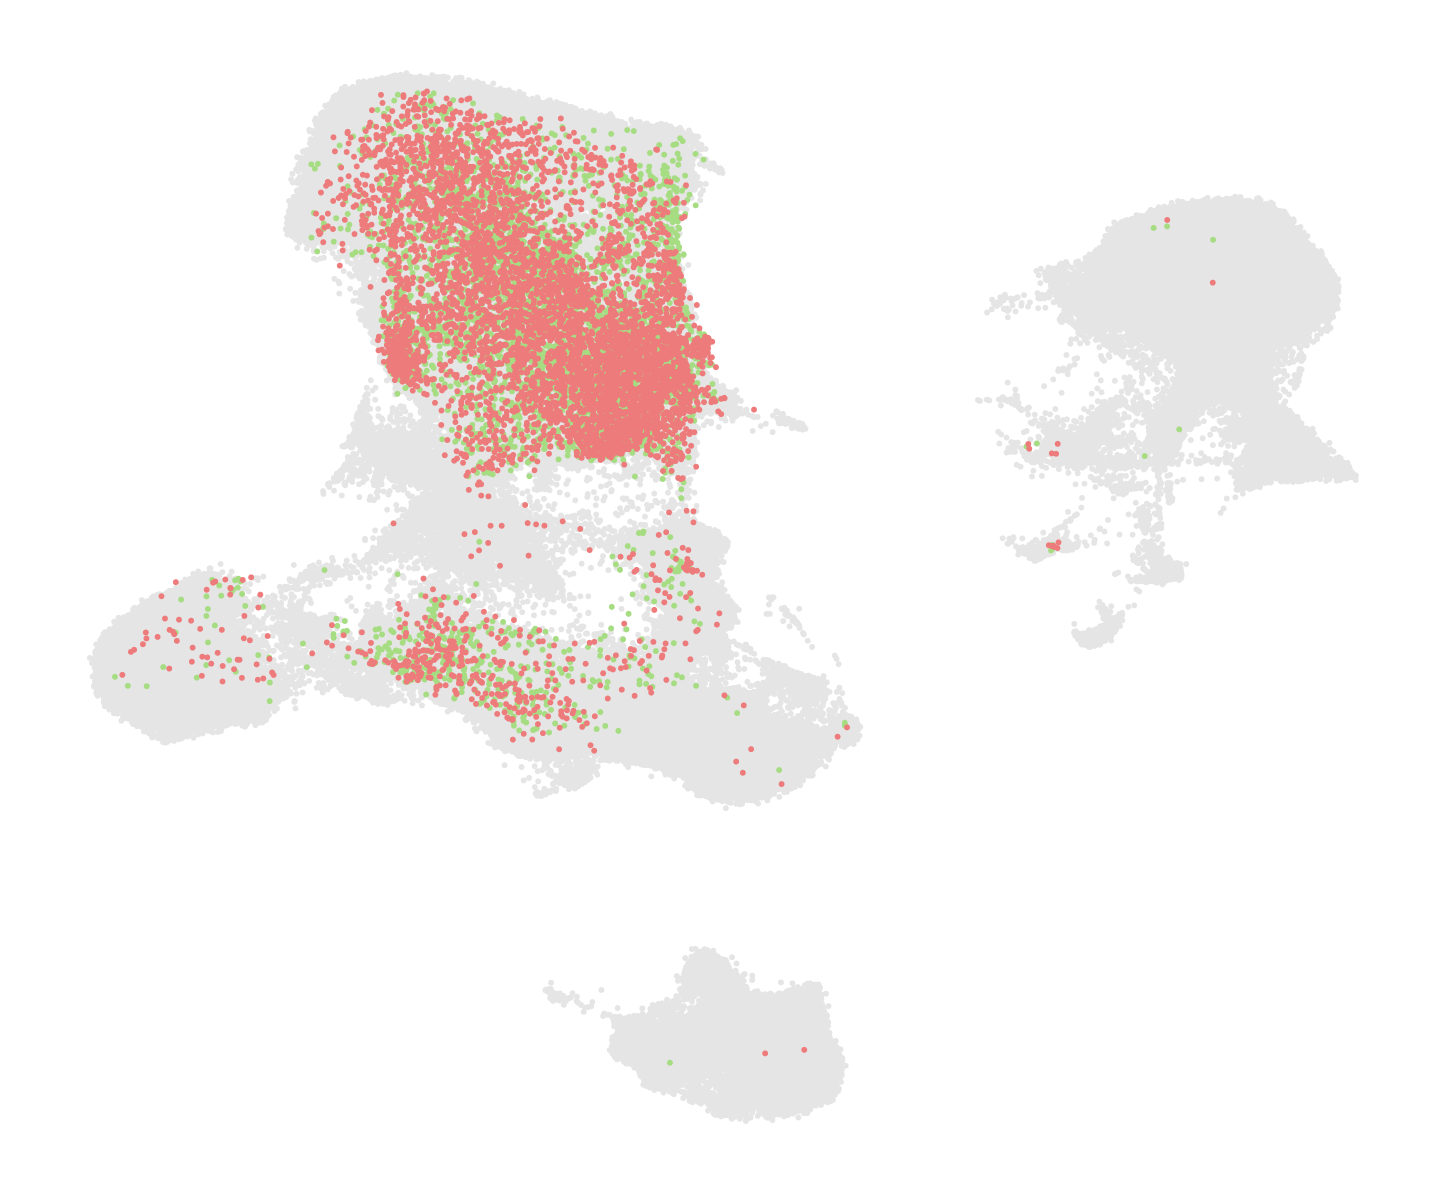

In [ ]:
# set groups for highlighting
obj@meta.data$highlight <- "Unselected"
select_mask <- obj@meta.data$batch %in% subset_names[29:30]

obj@meta.data$highlight[select_mask] <- as.character(obj@meta.data$batch[select_mask])

# Set colors
labels <- str_sort(unique(obj@meta.data$highlight[select_mask]))

pal <- c("#a6dc82", "#ed7b7b")
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(labels, "Unselected")

# plot
p2 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = F, rater_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 1, 
              shuffle = F, cols = cols, legend = T, return_plt = T) +
    labs(colour = "Batch") + theme(legend.position = "none")
p2
save_path = paste0("/root/workspace/wj/Workspace/Vscode_Workspace/single-cell-continue/MIRACLE-master/analysis/fig/", "single_query_neat_c1_batch")
ggsave(plot = p2, file = paste0(save_path, ".png"), width = L, height = L, limitsize = F)
ggsave(plot = p2, file = paste0(save_path, ".pdf"), width = L, height = L, limitsize = F)

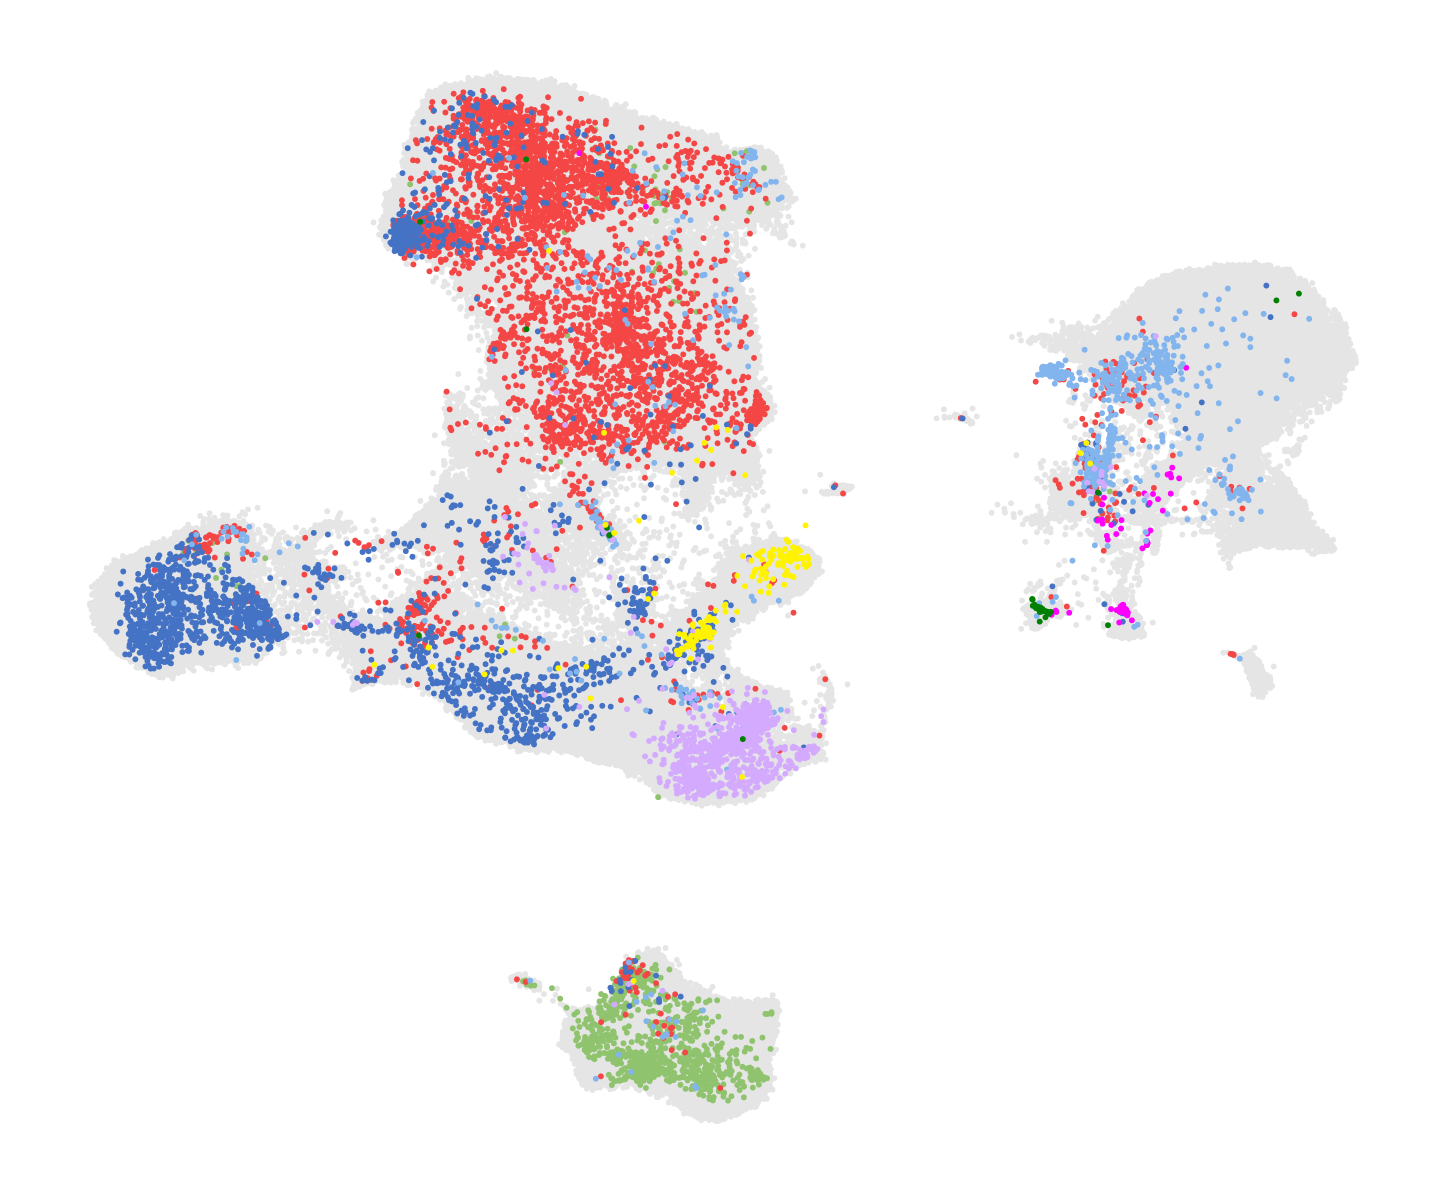

In [ ]:
# set groups for highlighting
obj@meta.data$highlight <- "Unselected"
select_mask <- obj@meta.data$batch %in% subset_names[29:30]

obj@meta.data$highlight[select_mask] <- as.character(obj@meta.data$l1[select_mask])

# Set colors
cell_label_unique <- unique(obj@meta.data$highlight[select_mask])
labels <- str_sort(cell_label_unique)

pal <- col_8
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")


# plot
p1 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = F, rater_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 1, 
              shuffle = F, cols = cols, legend = T, return_plt = T) +
    labs(colour = "Seurat cell type") + theme(legend.position = "none")
p1
save_path = paste0("/root/workspace/wj/Workspace/Vscode_Workspace/single-cell-continue/MIRACLE-master/analysis/fig/", "single_asap_c1_celltype")
ggsave(plot = p1, file = paste0(save_path, ".png"), width = L, height = L, limitsize = F)
ggsave(plot = p1, file = paste0(save_path, ".pdf"), width = L, height = L, limitsize = F)

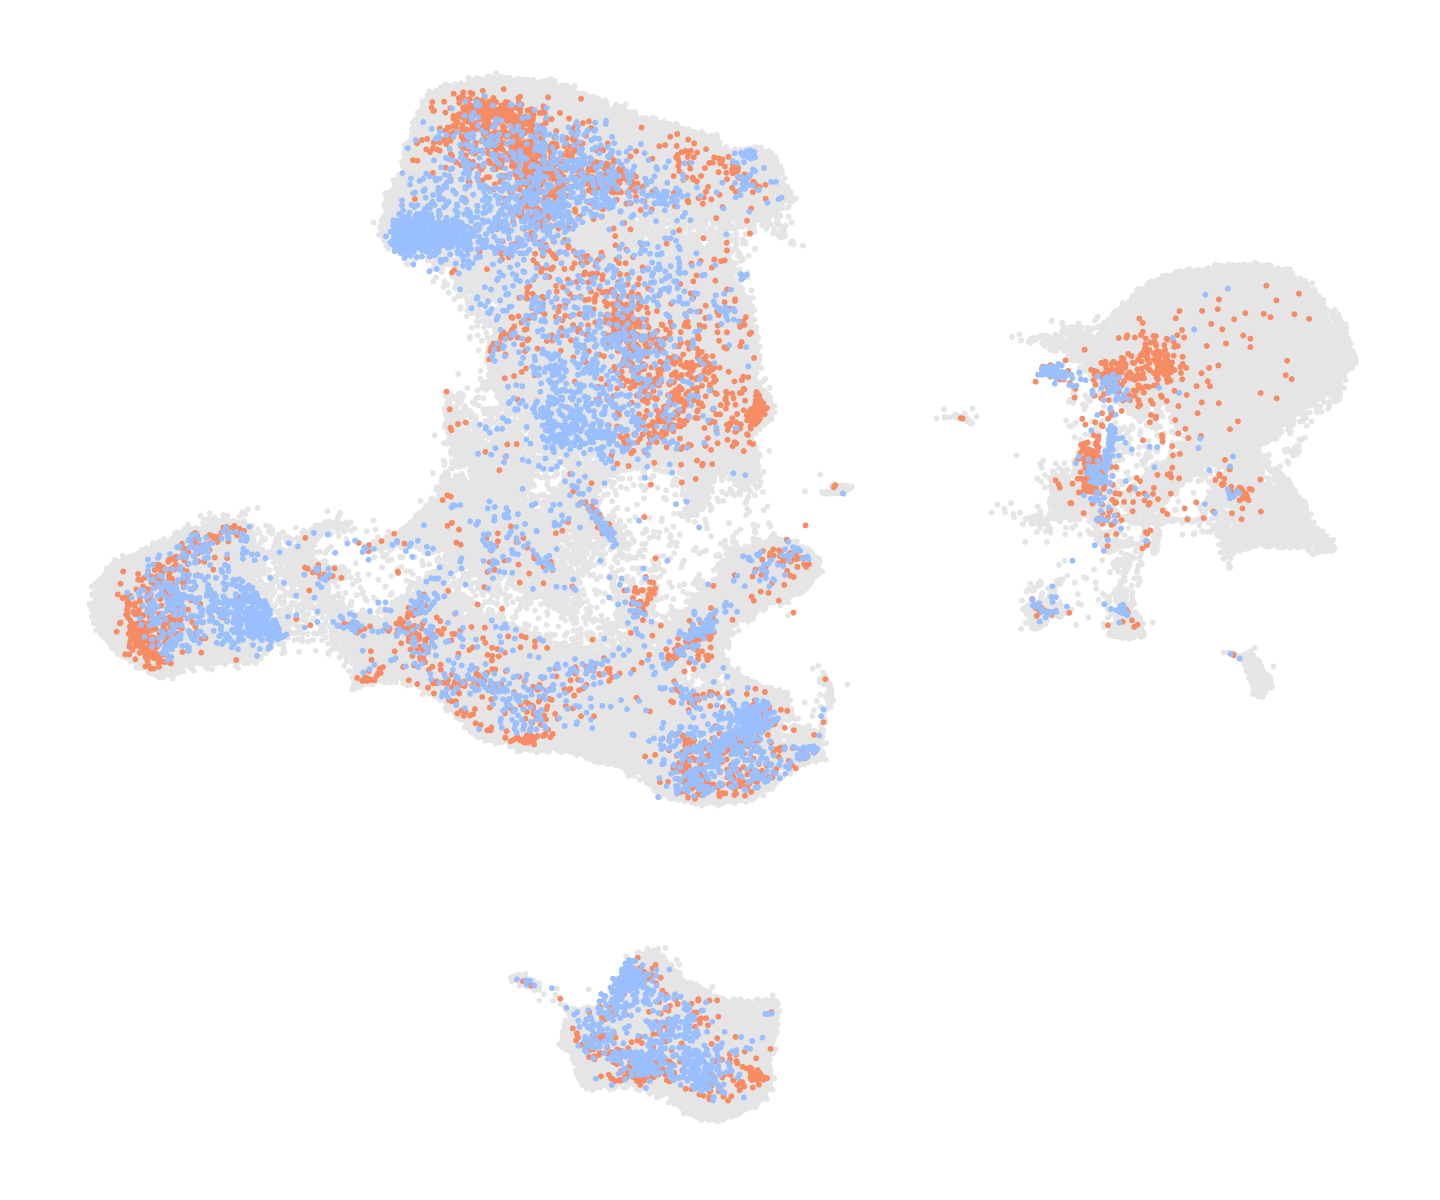

In [ ]:
# set groups for highlighting
obj@meta.data$highlight <- "Unselected"
select_mask <- obj@meta.data$batch %in% subset_names[29:30]

obj@meta.data$highlight[select_mask] <- as.character(obj@meta.data$batch[select_mask])

# Set colors
labels <- str_sort(unique(obj@meta.data$highlight[select_mask]))

pal <- c("#f78b64", "#9abfff")
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")

# plot
p2 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = F, rater_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 1, 
              shuffle = F, cols = cols, legend = T, return_plt = T) +
    labs(colour = "Batch") + theme(legend.position = "none")
p2
save_path = paste0("/root/workspace/wj/Workspace/Vscode_Workspace/single-cell-continue/MIRACLE-master/analysis/fig/", "single_asap_c1_batch")
ggsave(plot = p2, file = paste0(save_path, ".png"), width = L, height = L, limitsize = F)
ggsave(plot = p2, file = paste0(save_path, ".pdf"), width = L, height = L, limitsize = F)

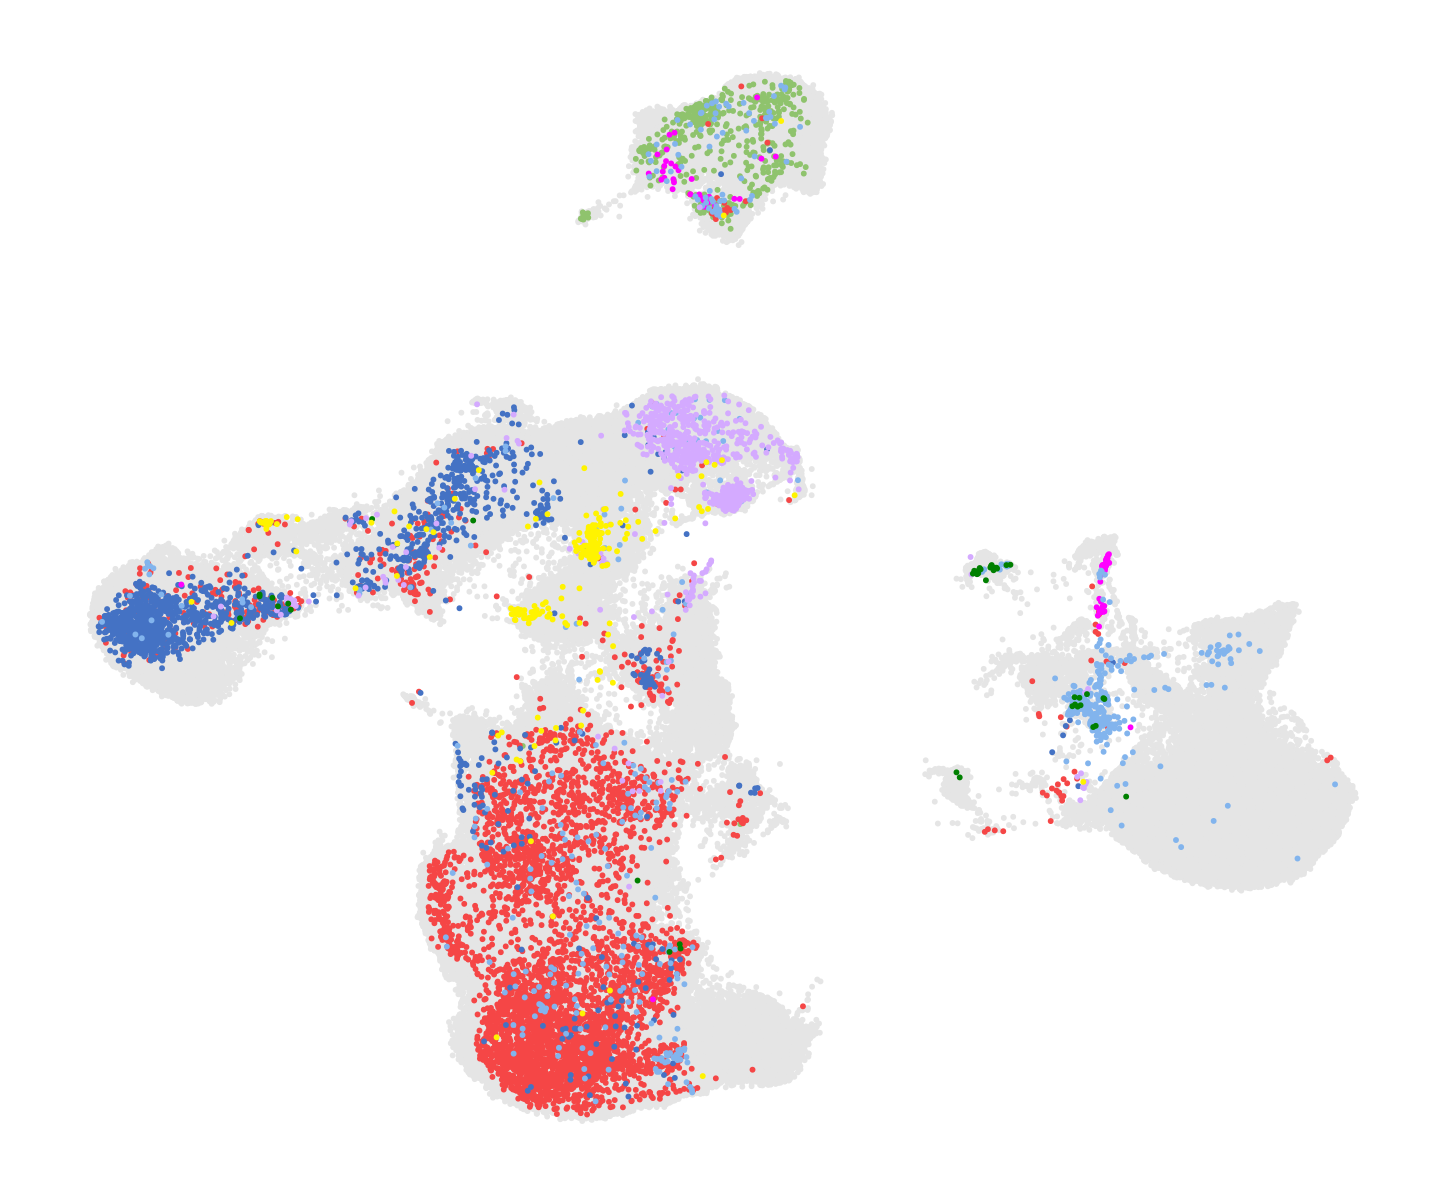

In [ ]:
# set groups for highlighting
obj@meta.data$highlight <- "Unselected"
select_mask <- obj@meta.data$batch %in% subset_names[29:30]

obj@meta.data$highlight[select_mask] <- as.character(obj@meta.data$l1[select_mask])

# Set colors
cell_label_unique <- unique(obj@meta.data$highlight[select_mask])
labels <- str_sort(cell_label_unique)

pal <- col_8
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")


# plot
p1 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = F, rater_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 1, 
              shuffle = F, cols = cols, legend = T, return_plt = T) +
    labs(colour = "Seurat cell type") + theme(legend.position = "none")
p1
save_path = paste0("/root/workspace/wj/Workspace/Vscode_Workspace/single-cell-continue/MIRACLE-master/analysis/fig/", "single_asap_cite_c1_celltype")
ggsave(plot = p1, file = paste0(save_path, ".png"), width = L, height = L, limitsize = F)
ggsave(plot = p1, file = paste0(save_path, ".pdf"), width = L, height = L, limitsize = F)

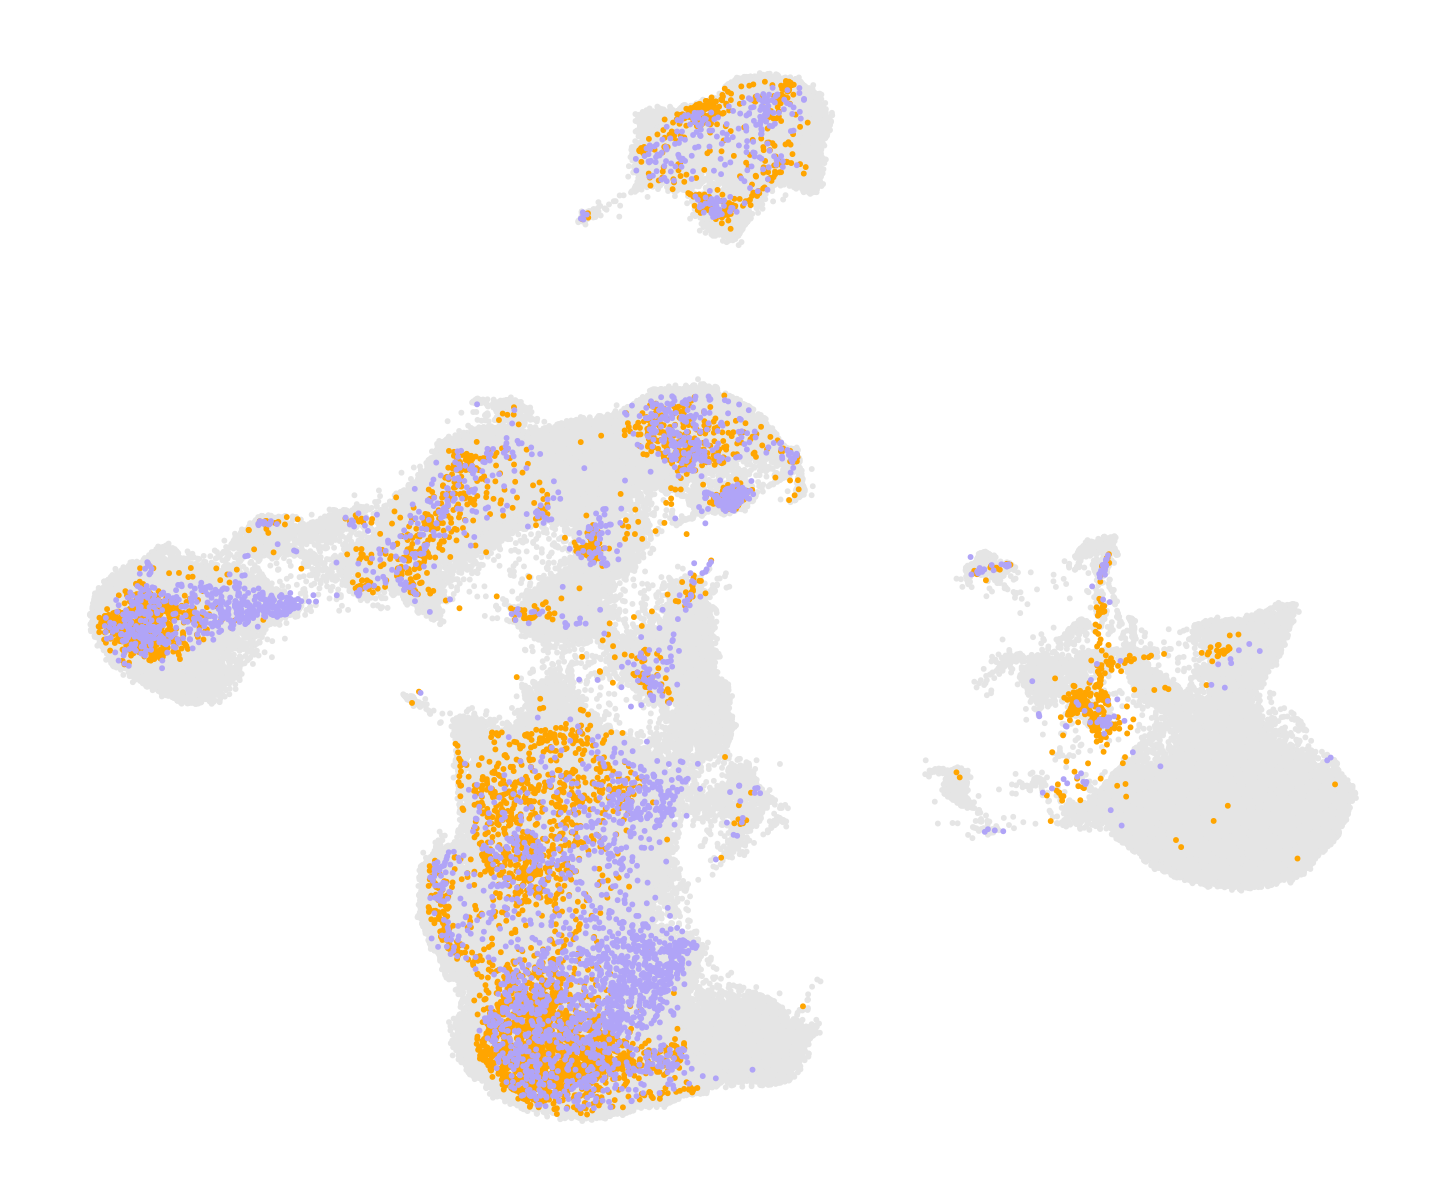

In [ ]:
# set groups for highlighting
obj@meta.data$highlight <- "Unselected"
select_mask <- obj@meta.data$batch %in% subset_names[29:30]

obj@meta.data$highlight[select_mask] <- as.character(obj@meta.data$batch[select_mask])

# Set colors
labels <- str_sort(unique(obj@meta.data$highlight[select_mask]))

pal <- c("#ffa500", "#b0a4f7")
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
cols <- c("#E5E5E5")
for (label in labels) {
    cols <- c(cols, label_to_color[[label]])
}

order <- c(rev(labels), "Unselected")

# plot
p2 <- dim_plot(obj, w = L+2, h = L, reduction = 'c.umap', no_axes = T, order = order, raster = F, rater_dpi = 600,
              split.by = NULL, group.by = "highlight", label = F, repel = T, label.size = 4, pt.size = 1, 
              shuffle = F, cols = cols, legend = T, return_plt = T) +
    labs(colour = "Batch") + theme(legend.position = "none")
p2
save_path = paste0("/root/workspace/wj/Workspace/Vscode_Workspace/single-cell-continue/MIRACLE-master/analysis/fig/", "single_asap_cite_c1_batch")
ggsave(plot = p2, file = paste0(save_path, ".png"), width = L, height = L, limitsize = F)
ggsave(plot = p2, file = paste0(save_path, ".pdf"), width = L, height = L, limitsize = F)